#Download:

Downloading Dataset from Kaggle:

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bornabarazandeh","key":"c3822d193b48775a56594b07f3149e6d"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation --force

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 706M/714M [00:04<00:00, 181MB/s]
100% 714M/714M [00:04<00:00, 184MB/s]


In [7]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

Libraries:

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(gpus[0], 'GPU')

#Dataset

Reading Dataset:

In [9]:
dataset_path = "/content/lgg-mri-segmentation/kaggle_3m"

folders = [folder for folder in os.listdir(dataset_path) if not folder.endswith(('.csv', '.md'))]

Reading Masks and Corresponded images:

In [10]:
def get_image_and_mask_paths(folder):
    image_paths = []
    mask_paths = []
    image_dict = {}
    mask_dict = {}
    for file in os.listdir(os.path.join(dataset_path, folder)):
        if file.endswith(".tif"):
            if file.endswith("_mask.tif"):
                mask_slice_number = int(file.split('_')[-2])
                mask_dict[mask_slice_number] = os.path.join(dataset_path, folder, file)
            else:
                image_slice_number = int(file.split('_')[-1].split('.')[0])
                image_dict[image_slice_number] = os.path.join(dataset_path, folder, file)

    sorted_image_paths = [v for k, v in sorted(image_dict.items())]
    sorted_mask_paths = [v for k, v in sorted(mask_dict.items())]
    return sorted_image_paths, sorted_mask_paths

In [17]:
image_path = []
mask_path = []

for folder in folders:
    images, masks = get_image_and_mask_paths(folder)
    image_path.extend(images)
    mask_path.extend(masks)

print("Number of photos:", len(image_path),"First Example:", image_path[0])
print("Number of masks:", len(mask_path),"First Example:", mask_path[0])


Number of photos: 3929 First Example: /content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
Number of masks: 3929 First Example: /content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif


Saving images and masks in a list:

In [18]:
from PIL import Image

In [19]:
def read_image(image_path, mask_path):
    masks = []
    images = []

    for image_p, mask_p in zip(image_path, mask_path):
        image = Image.open(image_p)
        mask = Image.open(mask_p)
        images.append(image)
        masks.append(mask)

    return images, masks

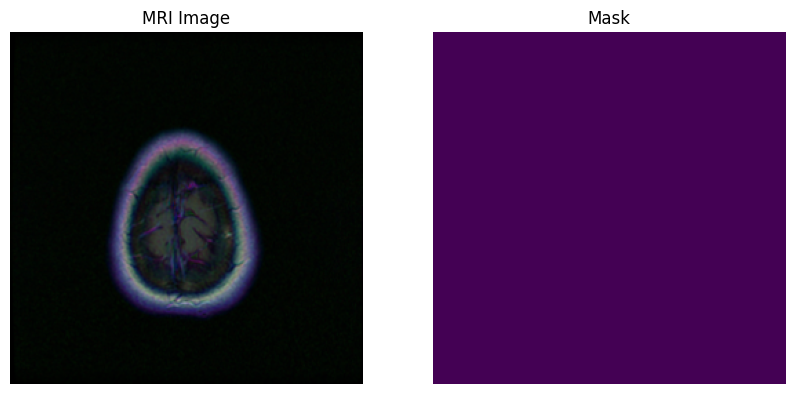

In [20]:
images = []
masks = []

images, masks = read_image(image_path, mask_path)

images = np.array(images)
masks = np.array(masks)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[400])
plt.title("MRI Image")
plt.axis('off')



plt.subplot(1, 2, 2)
plt.imshow(masks[400])
plt.title("Mask")
plt.axis('off')

plt.show()

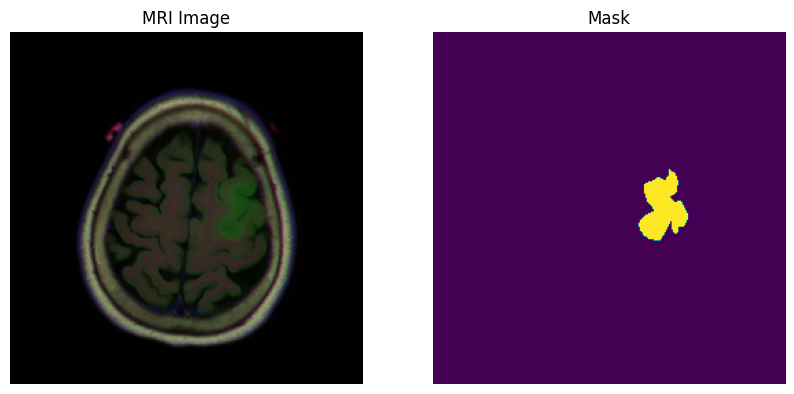

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[200])
plt.title("MRI Image")
plt.axis('off')



plt.subplot(1, 2, 2)
plt.imshow(masks[200])
plt.title("Mask")
plt.axis('off')

plt.show()

#Data Augmentation:

In [24]:
import albumentations as A

In [25]:
augmentation_pipeline = A.Compose([
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),

        A.RandomGamma(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        ])

In [26]:
def apply_augmentation(image, mask, augmentation_pipeline):

    augmented = augmentation_pipeline(image=image, mask=mask)

    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    return augmented_image, augmented_mask

In [27]:
augmented_image = []
augmented_mask = []
for image, mask in zip(images, masks):
    augment_image, augment_mask = apply_augmentation(image, mask, augmentation_pipeline)
    augmented_image.append(augment_image)
    augmented_mask.append(augment_mask)

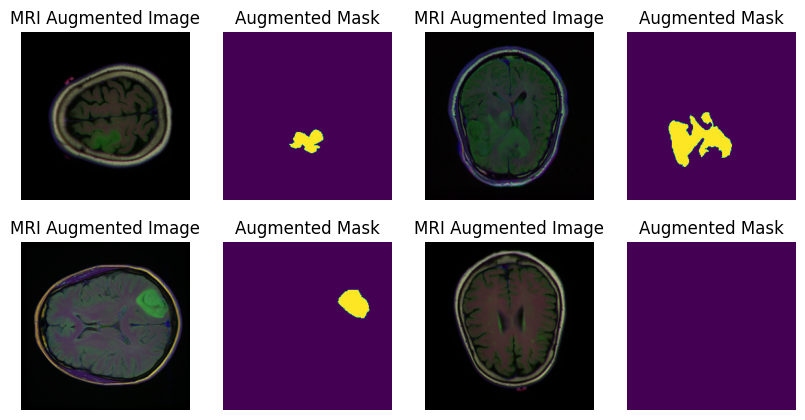

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 4, 1)
plt.imshow(augmented_image[200])
plt.title("MRI Augmented Image")
plt.axis('off')



plt.subplot(2, 4, 2)
plt.imshow(augmented_mask[200])
plt.title("Augmented Mask")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(augmented_image[250])
plt.title("MRI Augmented Image")
plt.axis('off')



plt.subplot(2, 4, 4)
plt.imshow(augmented_mask[250])
plt.title("Augmented Mask")
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(augmented_image[100])
plt.title("MRI Augmented Image")
plt.axis('off')



plt.subplot(2, 4, 6)
plt.imshow(augmented_mask[100])
plt.title("Augmented Mask")
plt.axis('off')


plt.subplot(2, 4, 7)
plt.imshow(augmented_image[190])
plt.title("MRI Augmented Image")
plt.axis('off')



plt.subplot(2, 4, 8)
plt.imshow(augmented_mask[190])
plt.title("Augmented Mask")
plt.axis('off')

plt.show()

In [14]:
midpoint = 4*len(augmented_image) // 10
new_aug_train_im = augmented_image[:midpoint]

new_aug_train_mask = augmented_mask[:midpoint]

In [16]:
midpoint = 45*len(images) // 100
new_aug_train_im = images[:midpoint]

new_aug_train_mask = masks[:midpoint]

In [17]:
total_im = augmented_image  + new_aug_train_im #images + new_aug_train_im#augmented_image #new_aug_train_im#
total_mask = augmented_mask + new_aug_train_mask #masks + new_aug_train_mask#augmented_mask#new_aug_train_mask#

print("Total Number of images:", len(total_im))
print("Total Number of masks:", len(total_mask))

Total Number of images: 5697
Total Number of masks: 5697


#Preprocess on Image and Mask

In [18]:
def image_process(image):

  resize = cv2.resize(image, (128, 128), interpolation=cv2.INTER_NEAREST)
  normalized = resize / 255.0

  return normalized

In [19]:
def mask_process(mask):

  resize = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
  #resize = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY)
  _, binary = cv2.threshold(resize, 127, 255, cv2.THRESH_BINARY)
  normalize = binary / 255.0
  normalize = np.expand_dims(normalize, axis=-1)

  return normalize

In [20]:
total_images = []
total_masks = []

for image, mask in zip(total_im, total_mask):
    im = image_process(image)
    ms = mask_process(mask)
    total_images.append(im)
    total_masks.append(ms)

print(len(total_images)," | ",total_images[0].shape)
print(len(total_masks)," | ",total_masks[0].shape)

5697  |  (128, 128, 3)
5697  |  (128, 128, 1)


#Splitting:

In [21]:
train_im, test_and_val_im, train_mask, test_and_val_mask  = train_test_split(total_images, total_masks, test_size=0.2, random_state=42)
test_im, val_im, test_mask, val_mask = train_test_split(test_and_val_im,test_and_val_mask, test_size=0.5, random_state=42)

print("Size of train images:", len(train_im))
print("Size of train mask:", len(train_mask))

print("Size of test images:", len(test_im))
print("Size of test mask:", len(test_mask))

print("Size of validation images:", len(val_im))
print("Size of validation mask:", len(val_mask))

Size of train images: 4557
Size of train mask: 4557
Size of test images: 570
Size of test mask: 570
Size of validation images: 570
Size of validation mask: 570


#Model Implementation:

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.models import Model

In [23]:
def unet(input_shape=(128, 128, 3)):

  inputs = Input(input_shape)

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
  drop1 = Dropout(0.1)(conv1)

  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(drop1)
  drop2 = Dropout(0.1)(conv2)


  pool1 = MaxPooling2D(pool_size=(2, 2))(drop2)


  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
  drop3 = Dropout(0.1)(conv3)

  conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(drop3)
  drop4 = Dropout(0.1)(conv4)


  pool2 = MaxPooling2D(pool_size=(2, 2))(drop4)


  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool2)
  drop5 = Dropout(0.1)(conv5)

  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same')(drop5)
  drop6 = Dropout(0.1)(conv6)


  pool3 = MaxPooling2D(pool_size=(2, 2))(drop6)


  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
  drop7 = Dropout(0.1)(conv7)

  conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same')(drop7)
  drop8 = Dropout(0.1)(conv8)


  pool4 = MaxPooling2D(pool_size=(2, 2))(drop8)


  conv9 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool4)
  drop9 = Dropout(0.1)(conv9)

  conv10 = Conv2D(512, 3, activation = 'relu', padding = 'same')(drop9)
  drop10 = Dropout(0.1)(conv10)


  up1 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop10))
  merge1 = concatenate([drop8,up1], axis = 3)


  conv11 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge1)
  drop11 = Dropout(0.1)(conv11)

  conv12 = Conv2D(256, 3, activation = 'relu', padding = 'same')(drop11)
  drop12 = Dropout(0.1)(conv12)


  up2 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop12))
  merge2 = concatenate([drop6,up2], axis = 3)


  conv13 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge2)
  drop13 = Dropout(0.1)(conv13)

  conv14 = Conv2D(128, 3, activation = 'relu', padding = 'same')(drop13)
  drop14 = Dropout(0.1)(conv14)


  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop14))
  merge3 = concatenate([drop4,up3], axis = 3)


  conv15 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge3)
  drop15 = Dropout(0.1)(conv15)

  conv16 = Conv2D(64, 3, activation = 'relu', padding = 'same')(drop15)
  drop16 = Dropout(0.1)(conv16)


  up4 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop16))
  merge4 = concatenate([drop2,up4], axis = 3)


  conv17 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge4)
  drop17 = Dropout(0.1)(conv17)

  conv18 = Conv2D(32, 3, activation = 'relu', padding = 'same')(drop17)
  drop18 = Dropout(0.1)(conv18)

  conv19 = Conv2D(1, 1, activation='sigmoid')(drop18)

  model = Model(inputs=inputs, outputs=conv19)
  return model

In [24]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['dropout[0][0]']             
                                                                                              

# IOU and Dice Coefficient Implementation:

In [25]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.0)

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1.0) / (union + 1.0)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

Must be 1 if same photos are given:

In [26]:
A = dice_coefficient(train_mask[300],train_mask[300])
B = iou(train_mask[300],train_mask[300])
print(A)
print(B)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


Must be near 0 if two non-equal images are given:

In [27]:
A = dice_coefficient(train_mask[300],train_mask[400])
B = iou(train_mask[300],train_mask[400])
print(A)
print(B)

tf.Tensor(0.0012970169, shape=(), dtype=float32)
tf.Tensor(0.0012970169, shape=(), dtype=float32)


#Model Training:

In [28]:
from keras.optimizers import Adam

In [29]:
train_im1 = np.stack(train_im, axis=0)
train_mask1 = np.stack(train_mask, axis=0)

val_im1 = np.stack(val_im, axis=0)
val_mask1 = np.stack(val_mask, axis=0)

with tf.device("GPU:0"):
  model = unet()
  optimizer = Adam(learning_rate =0.00001)
  model.compile(optimizer= optimizer, loss=dice_loss, metrics=['accuracy', iou, dice_coefficient])
  history = model.fit(train_im1, train_mask1, batch_size= 32, epochs=25,verbose=True, validation_data=(val_im1, val_mask1))

  #model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/25
143/143 [==============================] - 69s 324ms/step - loss: 0.9782 - accuracy: 0.0750 - iou: 0.0110 - dice_coefficient: 0.0218 - val_loss: 0.9725 - val_accuracy: 0.1908 - val_iou: 0.0140 - val_dice_coefficient: 0.0275
Epoch 2/25
143/143 [==============================] - 35s 246ms/step - loss: 0.9380 - accuracy: 0.7030 - iou: 0.0324 - dice_coefficient: 0.0619 - val_loss: 0.8930 - val_accuracy: 0.8647 - val_iou: 0.0570 - val_dice_coefficient: 0.1069
Epoch 3/25
143/143 [==============================] - 36s 251ms/step - loss: 0.8303 - accuracy: 0.9361 - iou: 0.0976 - dice_coefficient: 0.1715 - val_loss: 0.8197 - val_accuracy: 0.9270 - val_iou: 0.1012 - val_dice_coefficient: 0.1801
Epoch 4/25
143/143 [==============================] - 36s 252ms/step - loss: 0.5704 - accuracy: 0.9887 - iou: 0.2813 - dice_coefficient: 0.4299 - val_loss: 0.7073 - val_accuracy: 0.9664 - val_iou: 0.1774 - val_dice_coefficient: 0.2932
Epoch 5/25
143/143 [==============================] - 36s 25

In [30]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['iou'], label='IOU (Training)')
    plt.plot(history.history['val_iou'], label='IOU (Validation)')
    plt.title('IOU')
    plt.xlabel('Epoch')
    plt.ylabel('IOU')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coefficient'], label='Dice Coefficient (Training)')
    plt.plot(history.history['val_dice_coefficient'], label='Dice Coefficient (Validation)')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Loss (Training)')
    plt.plot(history.history['val_loss'], label='Loss (Validation)')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

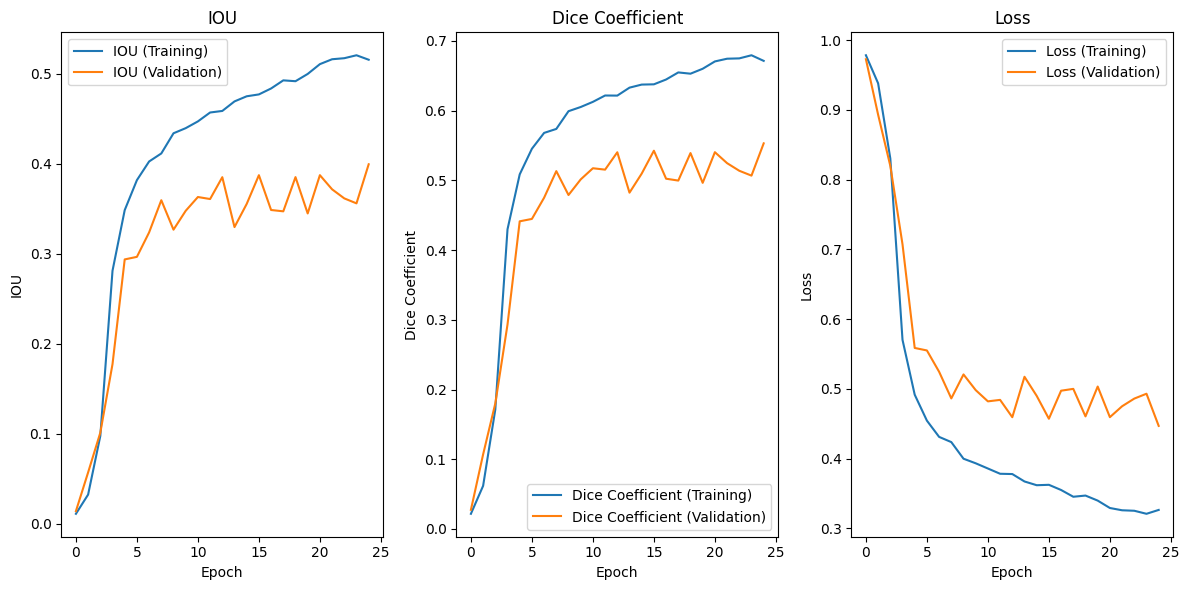

In [31]:
plot_history(history)

In [33]:
test_im1 = np.stack(test_im, axis=0)
test_mask1 = np.stack(test_mask, axis=0)

pred = model.predict(test_im1)

18/18 [==============================] - 1s 55ms/step


In [35]:
metrics = model.evaluate(test_im1, test_mask1)

18/18 [==============================] - 1s 57ms/step - loss: 0.4256 - accuracy: 0.9911 - iou: 0.4113 - dice_coefficient: 0.5753


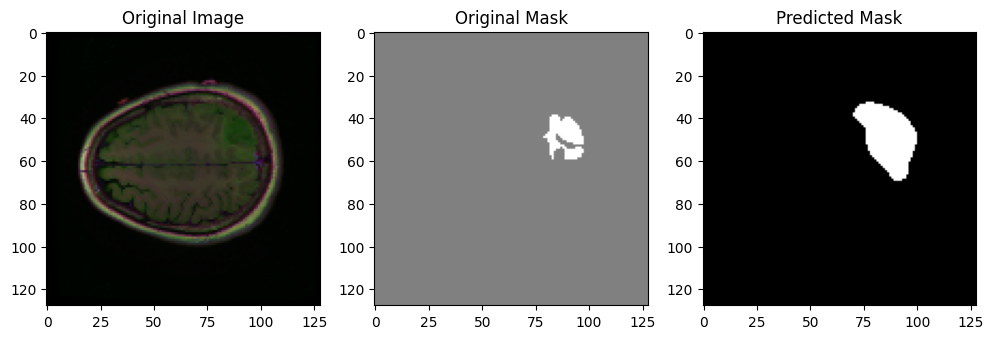

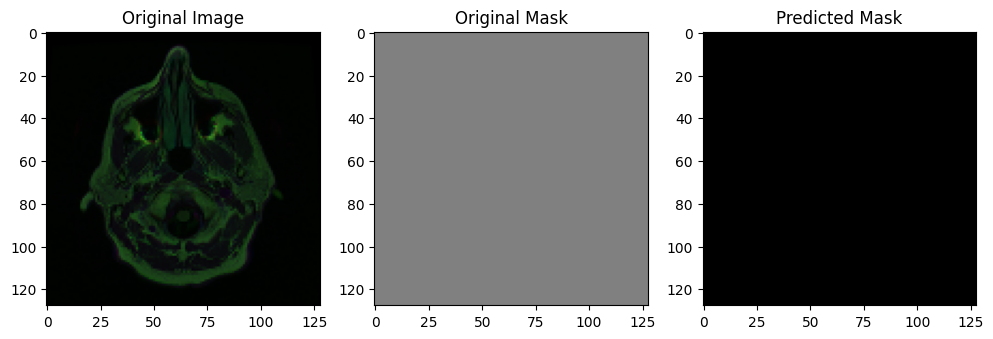

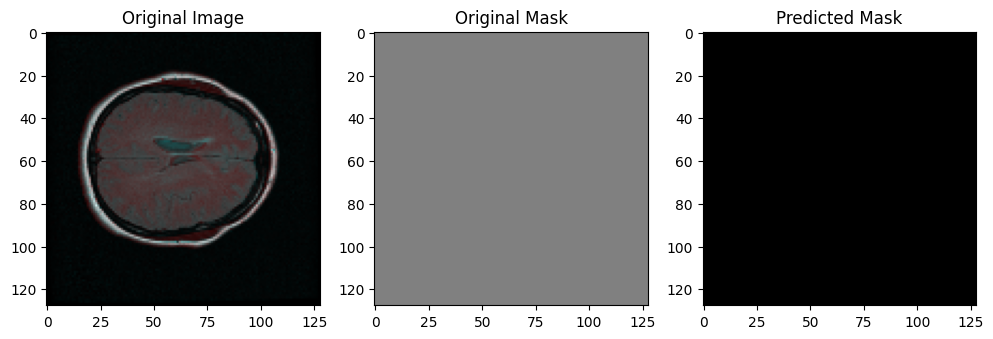

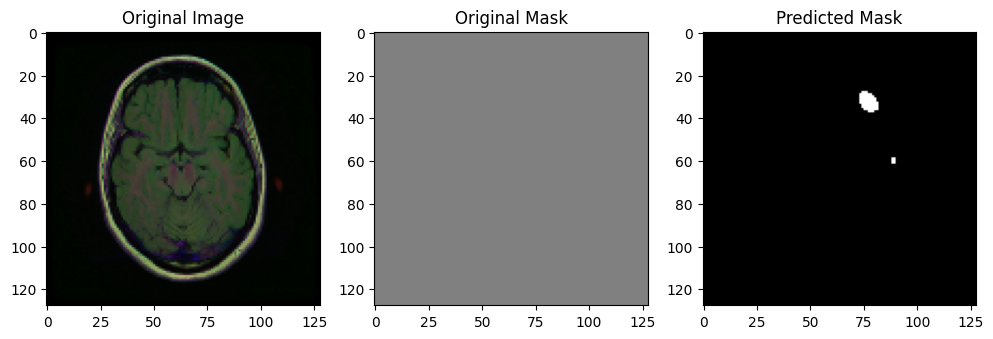

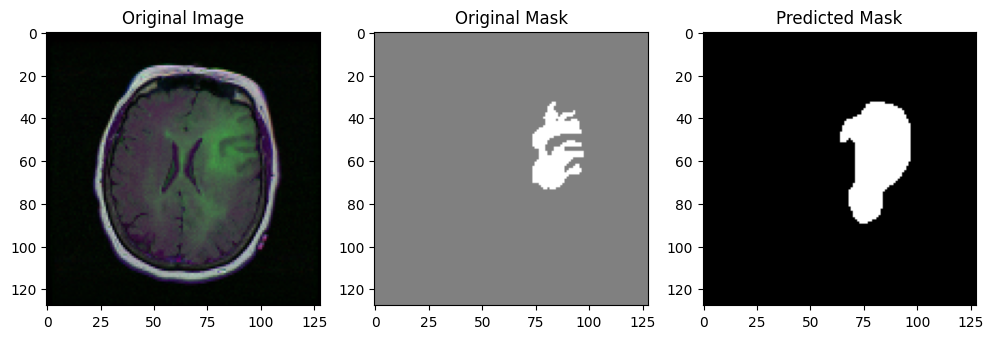

In [36]:
for i in range(5):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(test_im[i+20])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask[i+20], cmap='gray', alpha=0.5)
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred[i+20].squeeze() > 0.5, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()